In [30]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
import numpy as np
from dash import dcc, html
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import dash


In [31]:
data = pd.read_csv('Dados Brutos-PA-CFCT-comCNR.csv', parse_dates=[0])
data = data.drop(columns=['DATA'])

In [32]:
X = data.drop(columns=['CFCT'])
y = data['CFCT']

In [33]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Atributo': X.columns, 'Importância': importances})
feature_importances = feature_importances.sort_values(by='Importância', ascending=False)
atributos_mais_importantes_rf = feature_importances['Atributo'].to_list()


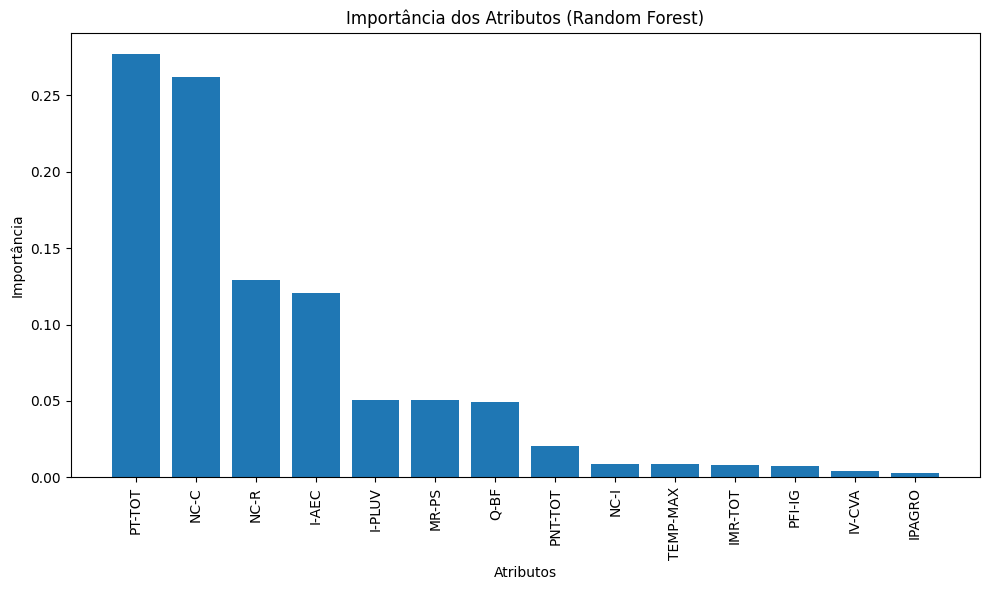

In [48]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(atributos_mais_importantes_rf)), feature_importances['Importância'], tick_label=atributos_mais_importantes_rf)
plt.xlabel('Atributos')
plt.ylabel('Importância')
plt.title('Importância dos Atributos (Random Forest)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [35]:
correlacoes = [pearsonr(data[attr], data['CFCT'])[0] for attr in X.columns]
correlacoes_df = pd.DataFrame({'Atributo': X.columns, 'Correlação de Pearson': correlacoes})
correlacoes_df = correlacoes_df.sort_values(by='Correlação de Pearson', ascending=False)
atributos_mais_importantes_correlacao = correlacoes_df['Atributo'].to_list()

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(atributos_mais_importantes_correlacao)), correlacoes_df['Correlação de Pearson'], tick_label=atributos_mais_importantes_correlacao)
plt.xlabel('Atributos')
plt.ylabel('Correlação de Pearson')
plt.title('Correlação de Pearson entre Atributos e CFCT')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

hetmap - histograma de correlação 

In [37]:
all_attributes = X.columns.tolist()

In [49]:
def fitness(individual):
    selected_attributes = [attr for attr, selected in zip(all_attributes, individual) if selected]
    fitness_value = np.sum(np.random.rand(len(selected_attributes)))  # Exemplo simples de função de fitness
    return (fitness_value)

In [51]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [52]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(all_attributes))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [53]:
NGEN = 10
CXPB = 0.7
MUTPB = 0.2

In [42]:
population = toolbox.population(n=50)

best_fitness_values = []
best_individuals = []

In [43]:
for gen in range(NGEN):
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    best_ind = tools.selBest(population, k=1)[0]
    best_fitness_values.append(best_ind.fitness.values)
    best_individuals.append(best_ind)

    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fitnesses = list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))


In [44]:
best_fitness_values = np.array(best_fitness_values)
gen_numbers = np.arange(1, NGEN + 1)
plt.figure(figsize=(10, 6))
plt.plot(gen_numbers, best_fitness_values, marker='o')
plt.xlabel('Geração')
plt.ylabel('Melhor Valor de Fitness')
plt.title('Convergência do Algoritmo Genético')
plt.grid(True)
plt.show()

In [45]:
best_individual = tools.selBest(population, k=1)[0]
selected_attributes = [attr for attr, selected in zip(all_attributes, best_individual) if selected]
print("Melhor conjunto de atributos:", selected_attributes)

Melhor conjunto de atributos: ['NC-R', 'NC-I', 'NC-C', 'PT-TOT', 'PNT-TOT', 'I-PLUV', 'IPAGRO', 'Q-BF', 'MR-PS', 'IMR-TOT', 'I-AEC', 'PFI-IG', 'IV-CVA']


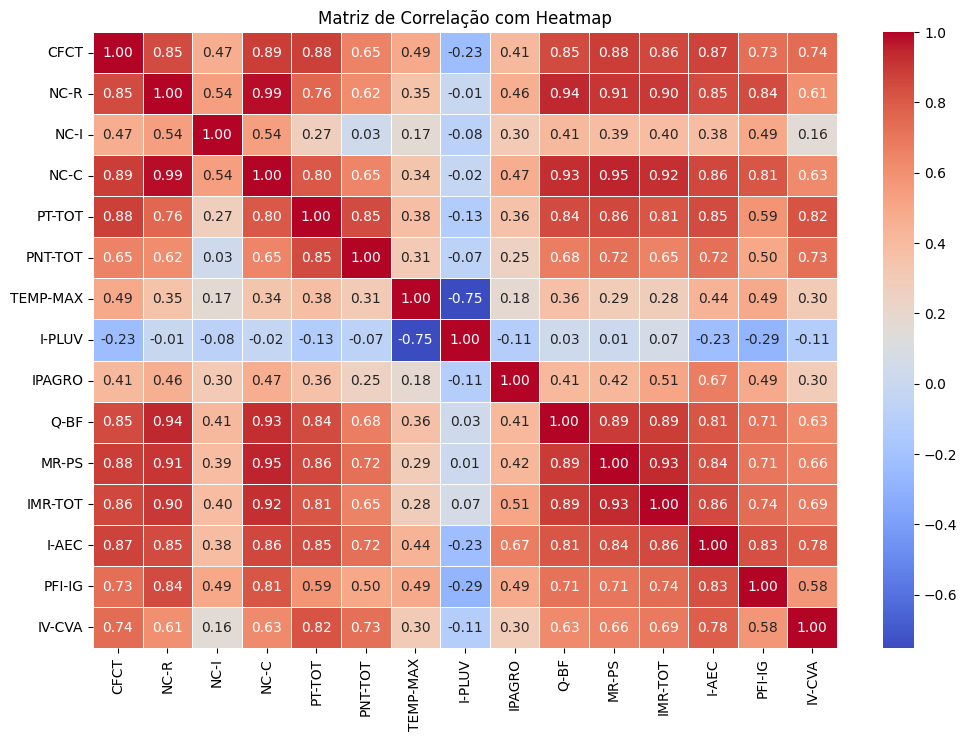

In [46]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação com Heatmap')
plt.show()

In [47]:
# # Criar um aplicativo Dash
# app = dash.Dash(__name__)

# # Layout do aplicativo
# app.layout = html.Div([
#     # Gráfico de barras para a importância das características no RandomForest
#     dcc.Graph(
#         id='importancia-atributos-rf',
#         figure=px.bar(
#             feature_importances,
#             x='Atributo',
#             y='Importância',
#             title='Importância dos Atributos (Random Forest)',
#             labels={'Importância': 'Importância', 'Atributo': 'Atributos'},
#             height=600
#         )
#     ),

#     # Gráfico de barras para a correlação de Pearson entre atributos e CFCT
#     dcc.Graph(
#         id='correlacao-pearson',
#         figure=px.bar(
#             correlacoes_df,
#             x='Atributo',
#             y='Correlação de Pearson',
#             title='Correlação de Pearson entre Atributos e CFCT',
#             labels={'Correlação de Pearson': 'Correlação de Pearson', 'Atributo': 'Atributos'},
#             height=600
#         )
#     ),

#     # Gráfico de heatmap para a matriz de correlação
#     dcc.Graph(
#         id='heatmap-correlacao',
#         figure=px.imshow(
#             data.corr(),
#             color_continuous_scale='coolwarm',
#             labels={'index': 'Atributos', 'columns': 'Atributos'},
#             title='Matriz de Correlação com Heatmap'
#         )
#     )
# ])

# # Executar o aplicativo Dash
# if __name__ == '__main__':
#     app.run_server(debug=True)